# Linear Models
Most of the independent variables appear to have a linear relationship with our dependent variable.  Therefore, applying a linear model to make predictions makes sense.  We'll start out by using an ordinary least squares multivariate regression model.  After that we will consider other linear and non-linear models we might use. 

## Import Libraries and Read In Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import pickle
linear_metrics = []

In [2]:
# reading in cleaned data exported from data cleaning notebook
df = pd.read_csv('cancer_reg_cleaned.csv', index_col=[0])

## Linear Regression Model
 


We will first take a look at an OLS regression model with all our independent variables.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
X = df.drop('TARGET_deathRate', axis=1)
y = df['TARGET_deathRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1989)

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
residuals = predictions - y_test

When we look at the metrics of our regression, it is important to understand what the metrics are telling us and which metrics we should place more focus on.  Our R-Squared overall is pretty low.  Although the model can explain a good deal of the variability in our data, this is not a very compelling number.

Since the primary purpose of this model is usefuleness as a predictive tool MAE and RMSE are probably better metrics to pay attention to.  The range of 99.7% (3 standard deviations) of our data is about 165.  An MAE of 14 and RMSE of 20 are not terrible, but I would say the predictive value of this model is pretty modest.

In [6]:
r2 = metrics.r2_score(y_true = y_test, y_pred = predictions)
MAE = metrics.mean_absolute_error(y_test, predictions)
MSE = metrics.mean_squared_error(y_test, predictions)
RMSE = np.sqrt(MSE)

print('R-Squared: {:.2%}'.format(r2))
print('MAE: {:.2f}'.format(MAE))
print('MSE: {:.2f}'.format(MSE))
print('RMSE: {:.2f}'.format(RMSE))

R-Squared: 50.15%
MAE: 14.26
MSE: 368.12
RMSE: 19.19


## Feature Selection
The above results show that our model is not very robust in predicting our dependent variable.  It's probably best do do some sort of feature selection.  I'm going to use SelectKBest to help determine how many, and which, features we should select. 

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression

i = 1

num_features = []

for i in range(1,26):
    features = np.array(X_train.columns)
    select = SelectKBest(score_func=f_regression, k=i)
    z = select.fit_transform(X_train, y_train)
    filter = select.get_support()
    features = features[filter]

    model = LinearRegression()
    model.fit(X_train[features], y_train)
    predictions = model.predict(X_train[features])
    r2 = model.score(X_train[features], y_train)
    MAE = metrics.mean_absolute_error(y_train, predictions)
    MSE = metrics.mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(metrics.mean_squared_error(y_train, predictions))
    num_features.append([i, features, r2, MAE, MSE, RMSE])

num_features = pd.DataFrame(num_features, columns=['Number of Features', 'Features', 'r2', 'MAE', 'MSE', 'RMSE'])

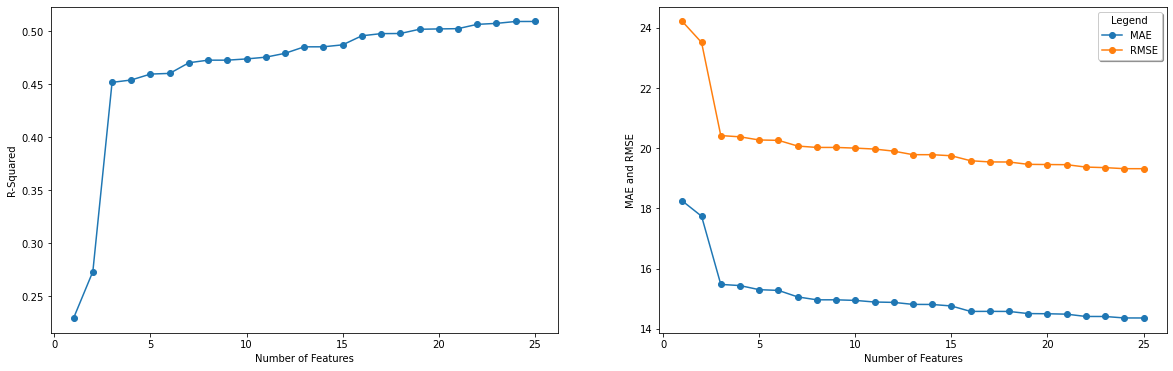

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
axs[0].plot(num_features['Number of Features'], num_features['r2'], marker="o")
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('R-Squared')
axs[1].plot(num_features['Number of Features'], num_features[['MAE', 'RMSE']], marker="o", label=['MAE', 'RMSE'])
axs[1].set_ylabel('MAE and RMSE')
axs[1].legend(loc="upper right", shadow=True, title="Legend", fancybox=True)
axs[1].set_xlabel('Number of Features')
plt.show()

When looking at our error metrics, it really does seem like the addition of features after the first few really do not add much to the improvement of the model.  Notice, at this time we are only looking at these metrics on our training set.  Therefore, to avoid overfitting to our training data, it makes sense to limit our features to the point where those metrics begin to flatten out.  We'll choose the top 7 features.

In [9]:
pd. set_option('display.max_colwidth', None) 
features = list(num_features['Features'][6])
print(features)

['incidenceRate', 'medIncome', 'povertyPercent', 'PctHS25_Over', 'PctBachDeg25_Over', 'PctPublicCoverage', 'PctPublicCoverageAlone']


In [10]:
X = df[features]
y = df['TARGET_deathRate']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1989)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
residuals = predictions - y_test

In [12]:
# export model for use in Executive Summary
OLS_model = 'OLS_model.sav'
pickle.dump(model, open(OLS_model, 'wb'))

In [13]:
r2 = metrics.r2_score(y_true = y_test, y_pred = predictions)
MAE = metrics.mean_absolute_error(y_test, predictions)
MSE = metrics.mean_squared_error(y_test, predictions)
RMSE = np.sqrt(MSE)

print('R-Squared: {:.2%}'.format(r2))
print('MAE: {:.2f}'.format(MAE))
print('MSE: {:.2f}'.format(MSE))
print('RMSE: {:.2f}'.format(RMSE))

OLS = {'metric': 'OLS', 'r2': r2, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}
linear_metrics.append(OLS)

R-Squared: 47.26%
MAE: 14.97
MSE: 389.46
RMSE: 19.73


Limiting the features didn't see to improve the performance of our model on our test set.  However, adding so much complexity to our model for the sake of such minor improvements in performance doesn't make a lot of sense.  I much prefer this simpler model, which is much easier to explain and interpret.

## Testing Assumption 1:  Linearity
The first assumption we will test is whether or not there is a linear relationship between our independent and dependent variables. Looking at the scatterplots of independent vs. dependent variables that I did above is a good way to test this assumption.  Another way is to look at the Residuals vs. Fitted Values.

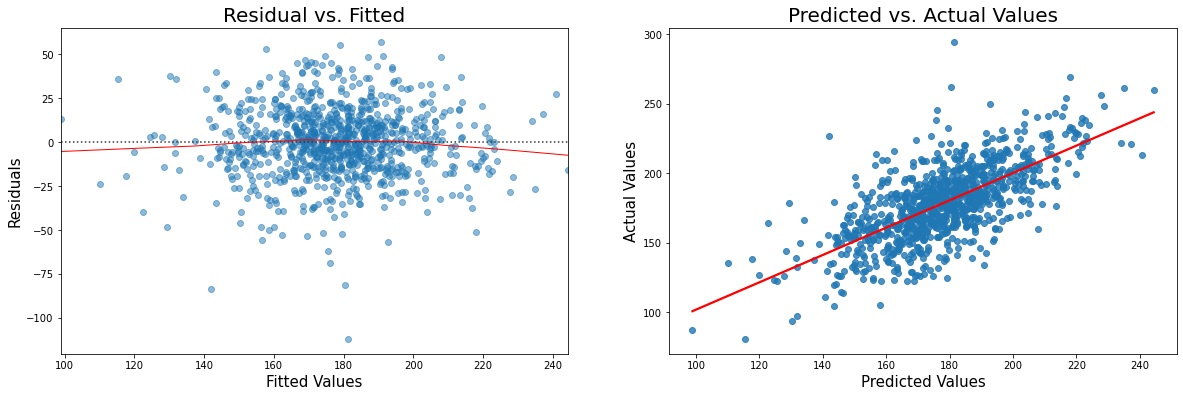

In [14]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
sns.residplot(x=predictions, y=residuals, lowess=True, 
              scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'lw':'1'}, ax=axs[0])
axs[0].set_title('Residual vs. Fitted', fontsize=20)
axs[0].set_xlabel('Fitted Values', fontsize=15)
axs[0].set_ylabel('Residuals', fontsize=15)
sns.regplot(x=predictions, y=y_test, ax=axs[1], ci=None, line_kws={'color':'red'})
axs[1].set_title('Predicted vs. Actual Values', fontsize=20)
axs[1].set_xlabel('Predicted Values', fontsize=15)
axs[1].set_ylabel('Actual Values', fontsize=15)
plt.show()

Generally for the Residual vs. Fitted plot we would want to see a relatively horizontal line around 0 and no discernable pattern of residual distribution.  With the Predicted vs. Actual Values, we want to see that most of the predicted values are distributed uniformly around the red line and that there is a clear linear relationship between predicted and actual values.  Both these plots look pretty good.

## Testing Assumption 2: Normality
The next assumption we will test is the normality of our residuals.  As you can see from the graphs below, our residuals appear to be generally normally distributed.  

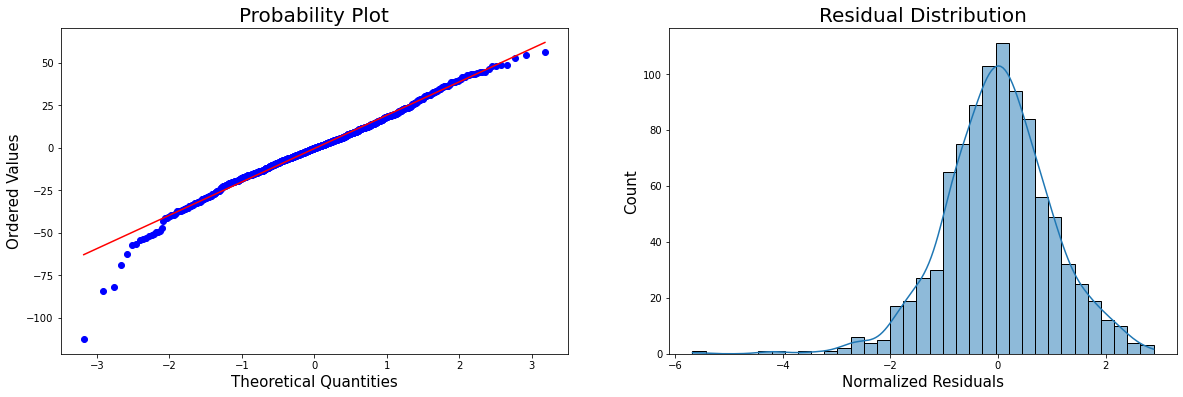

In [15]:
std_residuals = (residuals - residuals.mean())/np.std(residuals)

fig, axs = plt.subplots(1,2, figsize=(20,6))
stats.probplot(residuals, dist='norm', plot=axs[0])
axs[0].set_title('Probability Plot', fontsize=20)
axs[0].set_xlabel('Theoretical Quantities', fontsize=15)
axs[0].set_ylabel('Ordered Values', fontsize=15)
sns.histplot(std_residuals, kde=True, ax=axs[1])
axs[1].set_title('Residual Distribution', fontsize=20)
axs[1].set_xlabel('Normalized Residuals', fontsize=15)
axs[1].set_ylabel('Count', fontsize=15)
plt.show()

For the q-q plot, we want to see that the blue dots generally fall along the red line don't deviate sharply.  You can see on the tails of the distribution do deviate slightly, but overall this graph looks pretty good.  The distribution plot of normalized residuals looks good as well. 

## Testing Assumption 3:  Multicollinearity
The next assumption I will test will be Multicollinearity.  As we already investigated above, many of my independent variables have relationships with each other.  A good way to test for this is to look at Variance Inflation Factors.  Anything above 5 is worth looking at.  Interpreting the coefficients of any of these variables is going to be muddled as a result of these correlations, but the overall predictive ability of the model will not be affected. 

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
X_ = X.assign(const=1)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_.columns
vif_data['VIF'] = [variance_inflation_factor(X_.values, i) for i in range(len(X_.columns))]
vif_data['VIF'] = round(vif_data['VIF'],2)

In this case one of our variables seems to be on the bubble of being of concern.  `PctPublicCoverage` as we know from previous analysis has a high correlation (above 60%) with `PctPublicCoverageAlone`.  This value is not exceedingly high, so I am not too concerned.  But, it is worth noting and considering when we attempt to interpret the coeffecients of these variables in our regression model. 

In [18]:
vif_data[vif_data['VIF'] > 5].sort_values('VIF', ascending=False)

,Feature,VIF
7,const,457.02
6,PctPublicCoverageAlone,7.23
5,PctPublicCoverage,5.67


## Testing Assumption 4:  Homoscadasticity Check
The next thing we will do is check to see the the variance of our residuals is constant. Visually, we can do this by looking at our Residual vs. Fitted plot as well as a Scale-Location Plot.  We're looking for defined patterns and our lowess lines should be relatively flat.  Both these plots look pretty good.

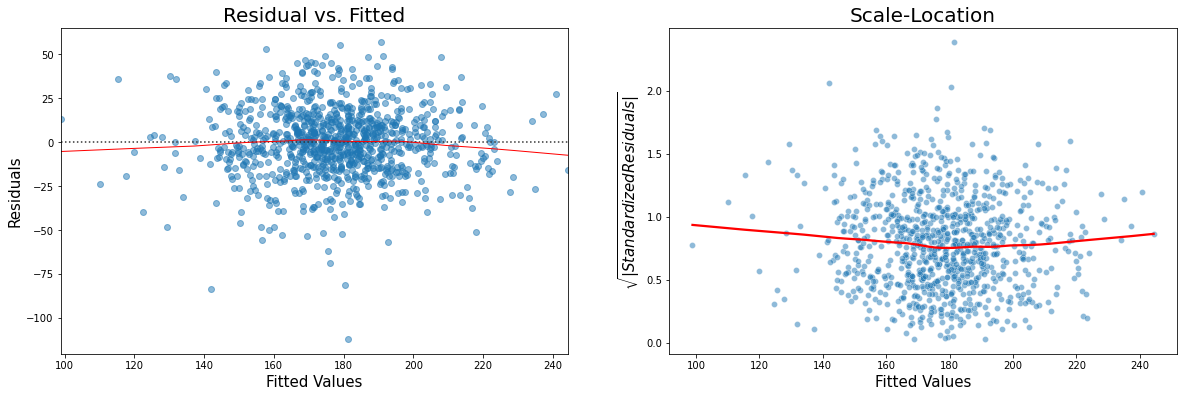

In [19]:
std_resid = (residuals - residuals.mean())/residuals.std()
sqrt_std_resid = np.abs(std_resid)**0.5

fig, axs = plt.subplots(1,2, figsize=(20,6))
sns.residplot(x=predictions, y=residuals, lowess=True, 
              scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'lw':'1'}, ax=axs[0])
axs[0].set_title('Residual vs. Fitted', fontsize=20)
axs[0].set_xlabel('Fitted Values', fontsize=15)
axs[0].set_ylabel('Residuals', fontsize=15)
sns.scatterplot(x=predictions, y=sqrt_std_resid, ax=axs[1], alpha=0.5)
sns.regplot(x=predictions, y=sqrt_std_resid, scatter=False, 
            ci=False, lowess=True, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_title('Scale-Location', fontsize=20)
axs[1].set_xlabel('Fitted Values', fontsize=15)
axs[1].set_ylabel('$\sqrt{|Standardized Residuals|}$', fontsize=15)

plt.show()

## Check for Influence Points

Finally, we will check our model for influential points.  This will help us locate any leverage points in our data as well as any outliers.  

In [20]:
import statsmodels.api as sm

X_train_ = X_train.assign(const=1)
model = sm.OLS(y_train, X_train_).fit()

In [21]:
model_leverage = model.get_influence().hat_matrix_diag
model_cooks = model.get_influence().cooks_distance
model_norm_residuals = model.get_influence().resid_studentized_internal

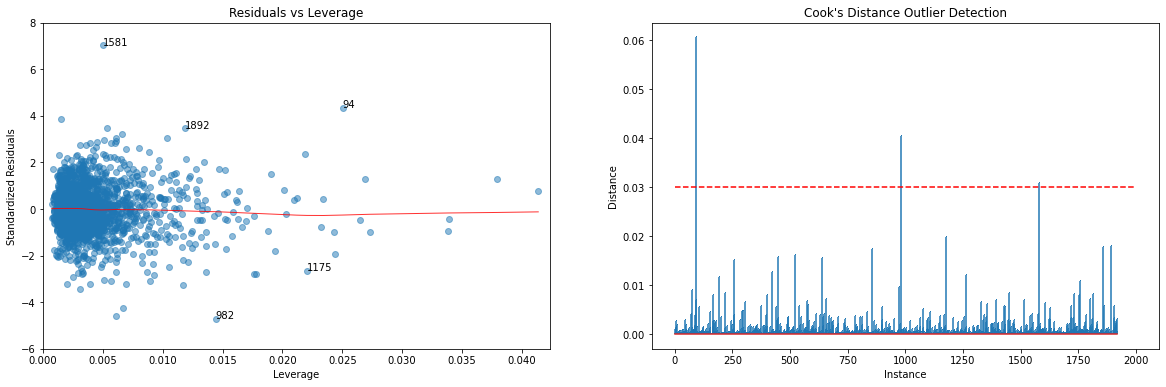

In [22]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
axs[0].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(x=model_leverage, y=model_norm_residuals, scatter =False, ci=False, lowess=True, ax=axs[0],
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axs[0].set_ylim(-6,8)
axs[0].set_xlim(0, max(model_leverage)+0.001)
axs[0].set_title('Residuals vs Leverage')
axs[0].set_xlabel('Leverage')
axs[0].set_ylabel('Standardized Residuals')

leverage_top_5 = np.flip(np.argsort(model_cooks), 0)[0][:5]

for i in leverage_top_5:
    axs[0].annotate(i,xy=(model_leverage[i], model_norm_residuals[i]));

axs[1].stem(model_cooks[0], markerfmt=',')
axs[1].set_xlabel('Instance')
axs[1].set_ylabel('Distance')
axs[1].hlines(0.03, 0, 2000, linestyles='dashed', colors='r')
axs[1].set_title("Cook's Distance Outlier Detection")

plt.show()


As we can see there is one point that looks like an outlier (94) and some other potential outliers (982 & 1581).  I inspected these values and didn't see anything unusual in the data.   In addition, I re-ran our regression without these points and there was no measurable difference in our results. So, at this time we'll just leave them in our analysis.

## Alternative Linear Models
Everyone is pretty familiar with our OLS model, but there are some other linear regression models that are worth looking at. We'll go ahead and restore our initial dataframe and train/test splits which include all features.

In [23]:
df = pd.read_csv('cancer_reg_cleaned.csv', index_col=[0])
X = df.drop('TARGET_deathRate', axis=1)
y = df['TARGET_deathRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1989)

### Ridge Regression

Another type of regression model we can look at is Ridge Regression.  Ridge Regression is a good tool to analyze models in which there are large number of coefficients and in which the model may suffer from multicollinearity.  By penalizing coefficients that take on large values, Ridge Regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity. 

In [24]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1).fit(X_train, y_train)
ridge_predict = ridge.predict(X_test)

In [25]:
r2 = metrics.r2_score(y_true = y_test, y_pred = ridge_predict)
MAE = metrics.mean_absolute_error(y_test, ridge_predict)
MSE = metrics.mean_squared_error(y_test, ridge_predict)
RMSE = np.sqrt(MSE)

print('R-Squared: {:.2%}'.format(r2))
print('MAE: {:.2f}'.format(MAE))
print('MSE: {:.2f}'.format(MSE))
print('RMSE: {:.2f}'.format(RMSE))
ridge = {'metric': 'ridge', 'r2': r2, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}
linear_metrics.append(ridge)

R-Squared: 50.15%
MAE: 14.27
MSE: 368.09
RMSE: 19.19


### Lasso Regression

Lasso regression is similar to Ridge in that it adds a penalty to the cost function to reduce large coefficients.  The main difference for Lasso is that it tends to cause coefficients to become 0.  Thus, Lasso not only reduces model complexity, it actually reduces model features. 

In [26]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.1).fit(X_train, y_train)
lasso_predict = lasso.predict(X_test)

In [27]:
r2 = metrics.r2_score(y_true = y_test, y_pred = lasso_predict)
MAE = metrics.mean_absolute_error(y_test, lasso_predict)
MSE = metrics.mean_squared_error(y_test, lasso_predict)
RMSE = np.sqrt(MSE)

print('R-Squared: {:.2%}'.format(r2))
print('MAE: {:.2f}'.format(MAE))
print('MSE: {:.2f}'.format(MSE))
print('RMSE: {:.2f}'.format(RMSE))
lasso = {'metric': 'lasso', 'r2': r2, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}
linear_metrics.append(lasso)

R-Squared: 50.21%
MAE: 14.28
MSE: 367.70
RMSE: 19.18


### ElasticNet Regression

ElasticNet Regression combines the regularization of both Lasso and Ridge Regressions.  It can reduce features like Lasso, but unlike Lasso it does not easily eliminate high collinearity coefficients.

In [28]:
from sklearn.linear_model import ElasticNet
enn = ElasticNet(alpha=0.1).fit(X_train, y_train)
enn_predict = enn.predict(X_test)

In [29]:
r2 = metrics.r2_score(y_true = y_test, y_pred = enn_predict)
MAE = metrics.mean_absolute_error(y_test, enn_predict)
MSE = metrics.mean_squared_error(y_test, enn_predict)
RMSE = np.sqrt(MSE)

print('R-Squared: {:.2%}'.format(r2))
print('MAE: {:.2f}'.format(MAE))
print('MSE: {:.2f}'.format(MSE))
print('RMSE: {:.2f}'.format(RMSE))
enn = {'metric': 'enn', 'r2': r2, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}
linear_metrics.append(enn)

R-Squared: 50.20%
MAE: 14.28
MSE: 367.75
RMSE: 19.18


In [30]:
#export linear model metrics
linear_metrics = pd.DataFrame(linear_metrics)
linear_metrics.set_index('metric')
linear_metrics.to_csv('linear_metrics.csv')